Downloads and Unzips the nature_12K data

In [ ]:
%%capture
import requests 
url = 'https://storage.googleapis.com/wandb_datasets/nature_12K.zip'
r = requests.get(url, allow_redirects=True)
open('nature_12K.zip', 'wb').write(r.content)
#!wget 'https://storage.googleapis.com/wandb_datasets/nature_12K.zip' #downloading data
!unzip nature_12K.zip

Import the necessary modules and load the cnn model

In [ ]:
import os
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

model = keras.models.load_model("my_best_model_A.h5") # load the model in which you want to perform back propagation 

This cell contains select_random_image function  
**Function name:** select_random_image  
**Description  :** selects the random image from the path provided from random class.  
**Arguments    :** path (path of the data set where you want to select the image randomly. This path should contain the classes as folders. By default nature12k data set has this structure)  
**Returns      :** selected image  

In [ ]:
def select_random_image(path):
  np.random.seed(5)  
  #classes Names should be same as the folder names in the data
  classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
  selected_class = np.random.choice(classes) # select the class 
  path = path+"/"+selected_class+"/"
  #path = "inaturalist_12K/train/"+selected_class+"/"    # From this path image is going to be selected randomly
  # Selecting the image randomly
  select_image = np.random.choice([
      x for x in os.listdir(path)
      if os.path.isfile(os.path.join(path, x))
  ])
  #loading the image using keras to plot and further processing in subsequent cells
  image = tf.keras.preprocessing.image.load_img(path+select_image, target_size=(200, 200))

  plt.imshow(image)
  plt.title("Image from the "+selected_class + " class")
  plt.show()
  return image

Select the random image

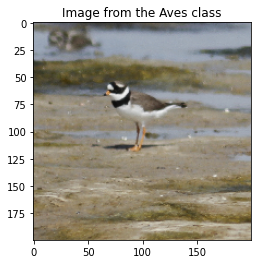

In [ ]:
path = "inaturalist_12K/train" # path of the data set
image = select_random_image(path)

This cell contains guided_back_propagation  
**Function name:** **guided_back_propagation**  
**Description :**performs guided back propagation and plots the images that excite the neuron  
**Arguments   :** number_of_neurons,model,image  
**Returns     :** Zero  

| **Variable name** |  **Description**   |
| :------------ | :-----|
| image    | image to perform back propagation            |
| model | cnn model instance |
|number_of_neurons | Number of neurons to see what excite those neurons|

In [ ]:
def guided_back_propagation(number_of_neurons,model,image):
  #number_of_neurons = 10   #number of neurons guided back propagation output needed
  #Getting the model parameters till last convolution layers output
  name = "conv2d_9"  # type the layer name here otherwise assign index_l value in else case
  for idx, layer in enumerate(model.layers):
      if layer.name == name:
          index_l = idx
          break
      else:
        index_l = -10    # index of the layer

  guided_backprop_model = tf.keras.models.Model(inputs = [model.inputs], outputs = [model.get_layer(index=index_l).output])

  # choose only the layers that have an activation attribute and below line exclude the first layer
  layer_dict = [layer for layer in guided_backprop_model.layers[1:] if hasattr(layer,'activation')]

  # custom gradient for guided  backpropagation
  @tf.custom_gradient
  def guidedbackpropRelu(x):
      def grad(dy):
          return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
      return tf.nn.relu(x), grad

  # In guided propagation we have to change the negative gradients to zero below code will achieve that.
  for l in layer_dict:
      if l.activation == tf.keras.activations.relu:
          l.activation = guidedbackpropRelu


  print("index of the conv2d layer is: ",index_l)
  # To select a neuron we need the shape of the layer
  conv2d_4_layer_shape = model.layers[index_l].output.shape[1:] #get the shape of the layer

  plt.figure(figsize=(60, 80))

  for i in range(0,number_of_neurons,1):
      # Index of a random pixel
      neuron_index_x = np.random.randint(0, conv2d_4_layer_shape[0])
      neuron_index_y = np.random.randint(0, conv2d_4_layer_shape[1])
      neuron_index_z = np.random.randint(0, conv2d_4_layer_shape[2])
      #To select the the only one neuron from a layer output we need to mask all the other neurons ouput
      # So we need a masking matrix Below code will generate that matrix 
      
      mask_matrix = np.zeros((1, *conv2d_4_layer_shape), dtype="float")
      mask_matrix[0, neuron_index_x, neuron_index_y, neuron_index_z] = 1

      # Calculating the gradients
      with tf.GradientTape() as tape:
          inputs = tf.cast(np.array([np.array(image)]), tf.float32)
          tape.watch(inputs)
          outputs = guided_backprop_model(inputs) * mask_matrix

      grads_visualize = tape.gradient(outputs, inputs)[0]

      img_guided_bp = np.dstack((grads_visualize[:, :, 0], grads_visualize[:, :, 1], grads_visualize[:, :, 2],)) 

      # input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers 
      # hence scaling down the values
      img_guided_bp = img_guided_bp - np.min(img_guided_bp)
      img_guided_bp /= img_guided_bp.max()
      plt.subplot(10, 1, i+1)
      plt.imshow(img_guided_bp)
      plt.axis("off")

  plt.show()
  return 0

performs the back propagation

index of the conv2d layer is:  12


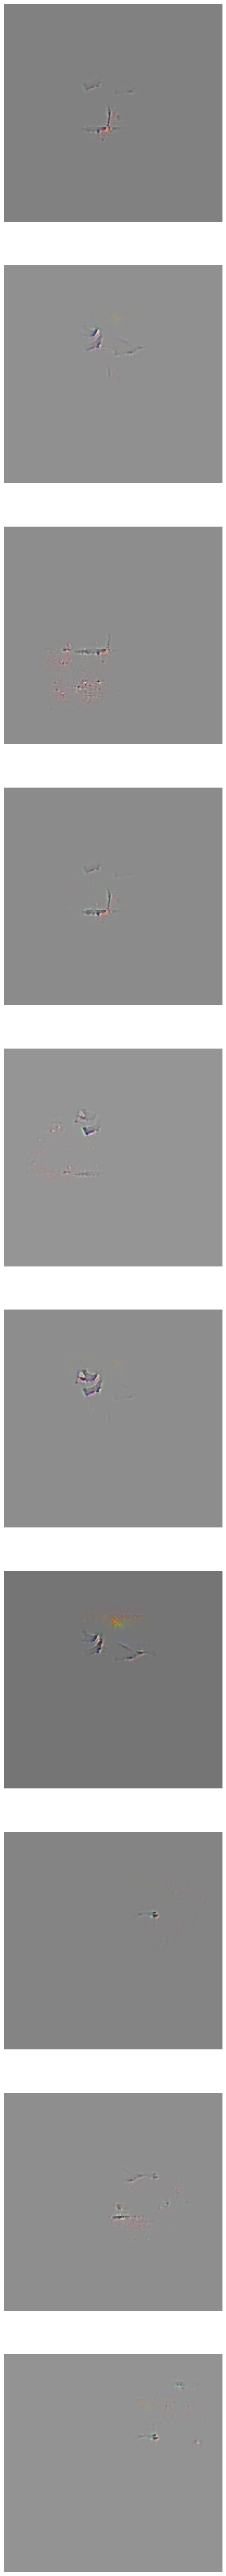

In [ ]:
number_of_neurons = 10 # number of neurons 
guided_back_propagation(number_of_neurons,model,image)